In [2]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
from loader import load_data
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 11.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

In [4]:
df = load_data(r"../data_hockey")
df = df.loc[df.Resultat != " -:-"].reset_index(drop=True)

In [5]:
# Get unique team names
teams = pd.concat([df["Home"], df["Away"]]).unique()

# Create a new DataFrame for one-hot encoding
encoded_df = pd.DataFrame(index=df.index)

# Create a column for each team and set default value to 0
for team in teams:
    encoded_df[team] = 0

# Mark the corresponding team column with 1
for i, row in df.iterrows():
    encoded_df.at[i, row["Home"]] = 1
    encoded_df.at[i, row["Away"]] = 1

# Concatenate the original DataFrame with the encoded columns
result_df = pd.concat([df, encoded_df], axis=1)

result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


for team in teams:
    team_subset = result_df[result_df[team] == 1].copy()
    team_subset.loc[:, team] = team_subset['Datum'].diff().dt.days - 1
    result_df.update(team_subset)


result_df['Home_rest_days'] = result_df.apply(lambda x: x[x['Home']], axis=1)
result_df['Away_rest_days'] = result_df.apply(lambda x: x[x['Away']], axis=1)
result_df.reset_index(drop=True, inplace=True)

In [6]:
# Convert the 'Datum' column to datetime
result_df['Datum'] = pd.to_datetime(result_df['Datum'], format='%d.%m.%Y')


# Split the Resultat into home and away goals
result_df['Home_goals'] = result_df['Resultat'].str.split(':').str[0].astype(int)
result_df['Away_goals'] = result_df['Resultat'].str.split(':').str[1].astype(int)

# Create a new dataframe in the Spotify format
home_df = result_df[['Home', 'Away', 'Home_goals', 'Home_rest_days', 'Tag']]
away_df = result_df[['Away', 'Home', 'Away_goals', 'Away_rest_days', 'Tag']]

hockey_df = pd.concat([home_df, away_df]).sort_values(by="Home").reset_index(drop=True).fillna(0)

In [7]:
# Create new dataframes for home and away games, now also include days_of_rest
home_df = hockey_df[['Home', 'Home_goals', 'Home_rest_days', 'Tag']].rename(columns={'Home':'Team', 'Home_goals':'Goals', 'Home_rest_days':'days_of_rest', 'Tag':'day_of_the_week'})
away_df = hockey_df[['Away', 'Away_goals', 'Away_rest_days', 'Tag']].rename(columns={'Away':'Team', 'Away_goals':'Goals', 'Away_rest_days':'days_of_rest',  'Tag':'day_of_the_week'})


# Concatenate these dataframes
flattened_df = pd.concat([home_df, away_df], axis=0).reset_index(drop=True)

# Assign a numerical code to each team
flattened_df['team_code'] = flattened_df['Team'].astype('category').cat.codes

In [8]:
# Define a dictionary to map German day abbreviations to day names
german_day_names = {
    'Mo': 'Monday',
    'Di': 'Tuesday',
    'Mi': 'Wednesday',
    'Do': 'Thursday',
    'Fr': 'Friday',
    'Sa': 'Saturday',
    'So': 'Sunday'
}

# Map German day abbreviations to day names in a new column
flattened_df['day_of_the_week'] = flattened_df['day_of_the_week'].map(german_day_names)

In [9]:
flattened_df

,Team,Goals,days_of_rest,day_of_the_week,team_code
0,EHC Biel-Bienne,7.0,3.0,Saturday,0
1,EHC Biel-Bienne,1.0,2.0,Friday,0
2,EHC Biel-Bienne,0.0,0.0,Tuesday,0
3,EHC Biel-Bienne,1.0,5.0,Friday,0
4,EHC Biel-Bienne,4.0,3.0,Saturday,0
...,...,...,...,...,...
9795,HC Davos,0.0,0.0,Saturday,7
9796,HC Ambri-Piotta,2.0,1.0,Sunday,6
9797,Fribourg-Gottéron,0.0,0.0,Thursday,3
9798,EHC Kloten,0.0,0.0,Saturday,1


# Hypothesis test 2
We want to see if days of the week affect team efficiency

# Research Question

We want to test the following hypothesis:
- Do games played on different days of the week have different average scores?

We assume that the distribution of the goals scored follows a poisson distribution


# Background information to set the prior
From a research we found the mean goals per game is 5.51 (https://www.sport12x.com/en/mathematics/ice-hockey). Given this we can divide the score between the two teams, resulting in a mean of 2.75 goals per team in one game.

We assume goals scored follow Poisson distribution, then the variance is equal to the mean. This means the standard deviation of goals per team is $SD = \sqrt{mean} = \sqrt{\frac{5.51}{2}} \approx 1.66$

We know that:
$$
\frac{\alpha}{\beta} = \mu
$$
$$
\frac{\alpha}{\beta^2} = \sigma^2
$$

therefore we can calculate alpha and beta as:
$$
\alpha = \frac{\mu^2}{\sigma^2}
$$
$$
\beta = \frac{\mu}{\sigma^2}
$$

In [11]:
mu = 2.75
sigma = 1.37

alpha = mu**2 / sigma**2
beta = mu / sigma**2
alpha, beta

(4.029250359635569, 1.4651819489583886)

# Prior for $\mu_{\text{Monday}}$, $\mu_{\text{Tuesday}}$, $\mu_{\text{Wednesday}}$, $\mu_{\text{Thursday}}$, $\mu_{\text{Friday}}$, $\mu_{\text{Saturday}}$, $\mu_{\text{Sunday}}$

* For each day of the week, we set the prior distribution for the average score as follows:

$$
\mu_{\text{Monday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Tuesday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Wednesday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Thursday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Friday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Saturday}}   \sim  Gam(4.03,1.47)
$$
$$
\mu_{\text{Sunday}}   \sim  Gam(4.03,1.47)
$$

* We assign the same prior distribution to each day of the week to avoid favoring any particular day over another. This ensures that our analysis is unbiased toward any specific day's performance.


# The Probabilistic Model


* We formulate a prior distribution for the average score of home teams as follows:

$$
\mu_{\text{Monday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Monday}} \sim Po(\mu_{\text{Monday}})
$$
$$
\mu_{\text{Tuesday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Tuesday}} \sim Po(\mu_{\text{Tuesday}})
$$
$$
\mu_{\text{Wednesday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Wednesday}} \sim Po(\mu_{\text{Wednesday}})
$$
$$
\mu_{\text{Thursday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Thursday}} \sim Po(\mu_{\text{Thursday}})
$$
$$
\mu_{\text{Friday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Friday}} \sim Po(\mu_{\text{Friday}})
$$
$$
\mu_{\text{Saturday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Saturday}} \sim Po(\mu_{\text{Saturday}})
$$
$$
\mu_{\text{Sunday}} \sim Gam(4.03,1.47)
$$
$$
\vec{y}_{\text{Sunday}} \sim Po(\mu_{\text{Sunday}})
$$

* We model the observed scores for each day of the week using the Poisson distribution with the parameter of the respective average score.

# Comparing the two means

In [18]:
# Extract scores for each day of the week
monday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Monday']['Goals']
tuesday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Tuesday']['Goals']
wednesday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Wednesday']['Goals']
thursday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Thursday']['Goals']
friday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Friday']['Goals']
saturday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Saturday']['Goals']
sunday_scores = flattened_df[flattened_df['day_of_the_week'] == 'Sunday']['Goals']

In [20]:
import pymc3 as pm

with pm.Model() as model_weekdays:
    # Prior
    mu_Monday = pm.Gamma('mu_Monday', alpha, beta)
    mu_Tuesday = pm.Gamma('mu_Tuesday', alpha, beta)
    mu_Wednesday = pm.Gamma('mu_Wednesday', alpha, beta)
    mu_Thursday = pm.Gamma('mu_Thursday', alpha, beta)
    mu_Friday = pm.Gamma('mu_Friday', alpha, beta)
    mu_Saturday = pm.Gamma('mu_Saturday', alpha, beta)
    mu_Sunday = pm.Gamma('mu_Sunday', alpha, beta)

    # Likelihood of scores for each day of the week
    y_Monday = pm.Poisson('y_Monday', mu=mu_Monday, observed=monday_scores)
    y_Tuesday = pm.Poisson('y_Tuesday', mu=mu_Tuesday, observed=tuesday_scores)
    y_Wednesday = pm.Poisson('y_Wednesday', mu=mu_Wednesday, observed=wednesday_scores)
    y_Thursday = pm.Poisson('y_Thursday', mu=mu_Thursday, observed=thursday_scores)
    y_Friday = pm.Poisson('y_Friday', mu=mu_Friday, observed=friday_scores)
    y_Saturday = pm.Poisson('y_Saturday', mu=mu_Saturday, observed=saturday_scores)
    y_Sunday = pm.Poisson('y_Sunday', mu=mu_Sunday, observed=sunday_scores)

    # Deterministic variable: difference of means
    diff_of_means = pm.Deterministic('diff_of_means', mu_Monday - mu_Friday)  # Example difference (change to suit your analysis)



You can find the C code in this temporary file: C:\Users\andre\AppData\Local\Temp\theano_compilation_error_aeo2cu94


Exception: ("Compilation failed (return status=1): C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `run':\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:99: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:124: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:130: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:158: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:195: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:210: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:479: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `_Py_INCREF':\r. c:/Users/andre/anaconda3/envs/Bayesian/include/object.h:459: undefined reference to `__imp__Py_NoneStruct'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `run':\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:485: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:244: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:265: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:173: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:179: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:515: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:514: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:516: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:259: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:279: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:294: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:328: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:349: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:216: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:343: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:300: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:397: undefined reference to `__imp_PyExc_RuntimeError'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `instantiate':\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:550: undefined reference to `__imp_PyExc_TypeError'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `_import_array':\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1480: undefined reference to `__imp_PyCapsule_Type'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1481: undefined reference to `__imp_PyExc_RuntimeError'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `PyInit_m01fa60f231767032485c0443319e00d1d5ac07bdc0931ee02e2555baae4ad34c':\r. C:/Users/andre/AppData/Local/Theano/compiledir_Windows-10-10.0.19045-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.8.13-64/tmp20pit6po/mod.cpp:583: undefined reference to `__imp_PyExc_ImportError'\r. C:\\Users\\andre\\AppData\\Local\\Temp\\cctjG2Hb.o: In function `_import_array':\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1512: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1502: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1524: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1476: undefined reference to `__imp_PyExc_AttributeError'\r. c:/Users/andre/anaconda3/envs/Bayesian/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1488: undefined reference to `__imp_PyExc_RuntimeError'\r. collect2.exe: error: ld returned 1 exit status\r. ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{4.029250359635569}, TensorConstant{1.4651819489583886}))')

In [ ]:
# Run the sampling
with model_weekdays:
    trace = pm.sample(1000, tune=1000)

WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot c

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a sca

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value f

array([[<AxesSubplot: title={'center': 'mu_Monday'}>,
        <AxesSubplot: title={'center': 'mu_Monday'}>],
       [<AxesSubplot: title={'center': 'mu_Tuesday'}>,
        <AxesSubplot: title={'center': 'mu_Tuesday'}>],
       [<AxesSubplot: title={'center': 'mu_Wednesday'}>,
        <AxesSubplot: title={'center': 'mu_Wednesday'}>],
       [<AxesSubplot: title={'center': 'mu_Thursday'}>,
        <AxesSubplot: title={'center': 'mu_Thursday'}>],
       [<AxesSubplot: title={'center': 'mu_Friday'}>,
        <AxesSubplot: title={'center': 'mu_Friday'}>],
       [<AxesSubplot: title={'center': 'mu_Saturday'}>,
        <AxesSubplot: title={'center': 'mu_Saturday'}>],
       [<AxesSubplot: title={'center': 'mu_Sunday'}>,
        <AxesSubplot: title={'center': 'mu_Sunday'}>],
       [<AxesSubplot: title={'center': 'diff_of_means'}>,
        <AxesSubplot: title={'center': 'diff_of_means'}>]], dtype=object)

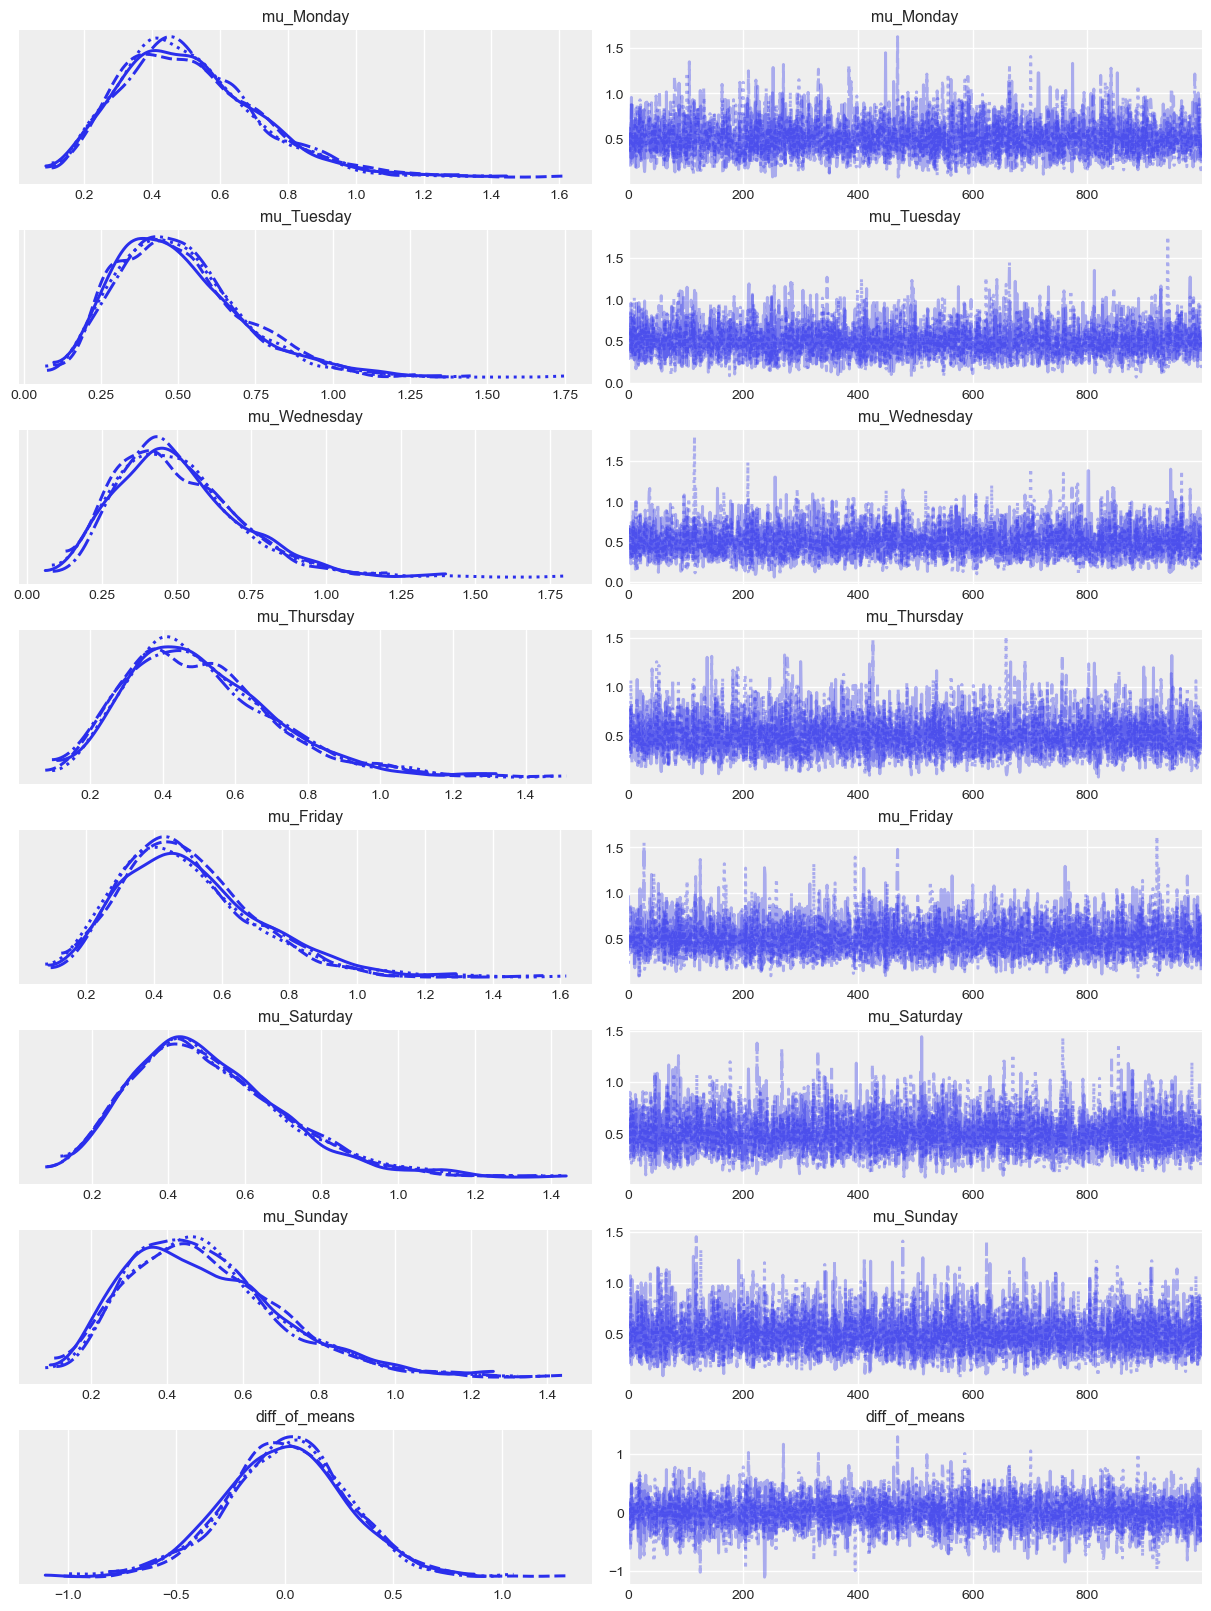

In [ ]:
az.plot_trace(trace)

In [ ]:
az.summary(trace, hdi_prob=0.95)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value f

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_Monday,0.508,0.202,0.159,0.899,0.003,0.002,4352.0,2464.0,1.0
mu_Tuesday,0.499,0.201,0.184,0.935,0.003,0.002,4018.0,2862.0,1.0
mu_Wednesday,0.502,0.202,0.155,0.898,0.003,0.002,4287.0,2694.0,1.0
mu_Thursday,0.503,0.204,0.146,0.899,0.003,0.002,4505.0,2858.0,1.0
mu_Friday,0.497,0.199,0.151,0.883,0.003,0.002,4581.0,2526.0,1.0
mu_Saturday,0.503,0.199,0.156,0.887,0.003,0.002,5131.0,2808.0,1.0
mu_Sunday,0.499,0.202,0.165,0.903,0.003,0.002,5131.0,3134.0,1.0
diff_of_means,0.010,0.282,-0.549,0.569,0.004,0.004,4444.0,3194.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/christian/miniforge3/envs/bda/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value f

<AxesSubplot: title={'center': 'diff_of_means'}>

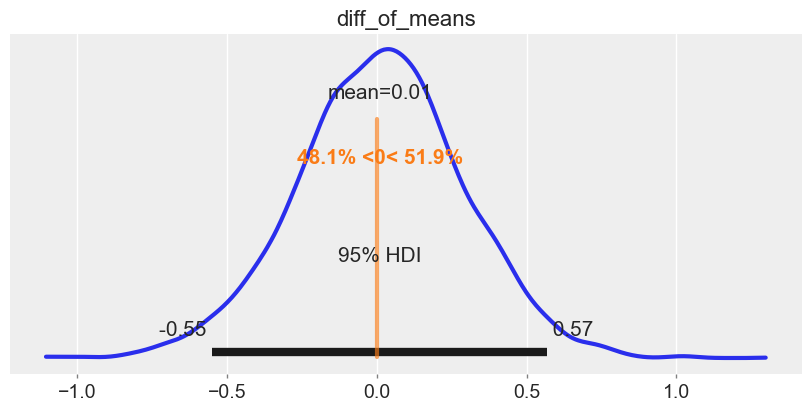

In [ ]:
az.plot_posterior(trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95)

Got error No model on context stack. trying to find log_likelihood in translation.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from 

<AxesSubplot: title={'center': 'diff_of_means'}>

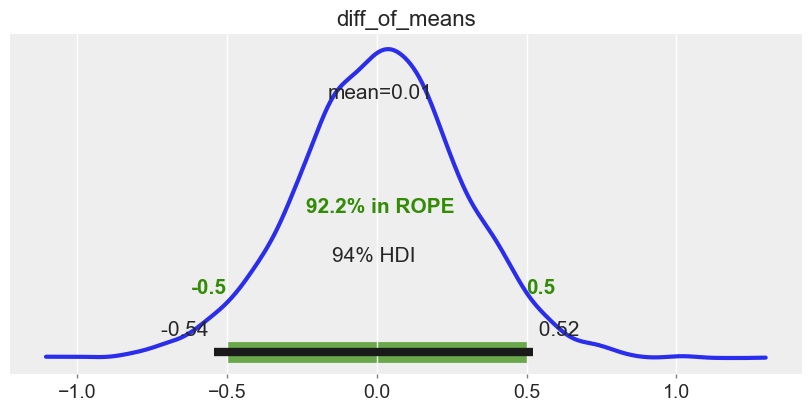

In [ ]:
az.plot_posterior(trace,  var_names="diff_of_means", rope=[-0.5,0.5])

In [ ]:
samples = az.extract(trace)
diff_samples = samples.diff_of_means.values
p_significant_positive =  ((diff_samples > 0.5).sum()) / len(diff_samples)
p_significant_negative = ((diff_samples < -0.5).sum()) / len(diff_samples)
p_practically_eq = 1 -  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

Got error No model on context stack. trying to find log_likelihood in translation.
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{sub,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: Elemwise{switch,no_inplace}.0
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size: TensorConstant{[]}
WARNING (theano.tensor.opt): Cannot construct a scalar test value from 

p_significant_positive:  0.041
p_practically_eq:  0.921
p_significant_negative:  0.038


# Posterior predictive checks

In [ ]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with model:
     ppc = pm.sample_posterior_predictive(trace, samples=300)
    
# The density is too low in the bulk of the distribution, for both groups. 
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

NameError: name 'model' is not defined

## Prior sensitivity

In [21]:
mu_weekdays = 2.75 
# Double the sigma to have a more diffuse prior
sigma_weekdays = sigma * 2

alpha_weekdays = mu_weekdays**2 / sigma_weekdays**2
beta_weekdays = mu_weekdays / sigma_weekdays**2


In [ ]:
with pm.Model() as model_weekdays_sensitivity:
    # Prior
    mu_Monday_new = pm.Gamma('mu_Monday_new', alpha_weekdays, beta_weekdays)
    mu_Tuesday_new = pm.Gamma('mu_Tuesday_new', alpha_weekdays, beta_weekdays)
    mu_Wednesday_new = pm.Gamma('mu_Wednesday_new', alpha_weekdays, beta_weekdays)
    mu_Thursday_new = pm.Gamma('mu_Thursday_new', alpha_weekdays, beta_weekdays)
    mu_Friday_new = pm.Gamma('mu_Friday_new', alpha_weekdays, beta_weekdays)
    mu_Saturday_new = pm.Gamma('mu_Saturday_new', alpha_weekdays, beta_weekdays)
    mu_Sunday_new = pm.Gamma('mu_Sunday_new', alpha_weekdays, beta_weekdays)

    # Likelihood of each day
    y_Monday_new = pm.Poisson('y_Monday_new', mu=mu_Monday_new, observed=home_scores_by_weekday['Monday'])
    y_Tuesday_new = pm.Poisson('y_Tuesday_new', mu=mu_Tuesday_new, observed=home_scores_by_weekday['Tuesday'])
    y_Wednesday_new = pm.Poisson('y_Wednesday_new', mu=mu_Wednesday_new, observed=home_scores_by_weekday['Wednesday'])
    y_Thursday_new = pm.Poisson('y_Thursday_new', mu=mu_Thursday_new, observed=home_scores_by_weekday['Thursday'])
    y_Friday_new = pm.Poisson('y_Friday_new', mu=mu_Friday_new, observed=home_scores_by_weekday['Friday'])
    y_Saturday_new = pm.Poisson('y_Saturday_new', mu=mu_Saturday_new, observed=home_scores_by_weekday['Saturday'])
    y_Sunday_new = pm.Poisson('y_Sunday_new', mu=mu_Sunday_new, observed=home_scores_by_weekday['Sunday'])

    # The deterministic variable for the difference of means
    diff_of_means_weekdays_new = pm.Deterministic('diff_of_means_weekdays_new', 
                                                  mu_Monday_new - mu_Tuesday_new + mu_Wednesday_new - mu_Thursday_new + 
                                                  mu_Friday_new - mu_Saturday_new + mu_Sunday_new - mu_Monday_new)


In [ ]:
with model_sensitivity:
    trace_sensitivity = pm.sample(return_inferencedf=True)

In [ ]:
az.summary(trace_sensitivity, hdi_prob=0.95)


In [ ]:
az.plot_posterior(trace_sensitivity,  var_names="diff_of_means_new", ref_val=0, hdi_prob=0.95)

In [ ]:
az.plot_posterior(trace_sensitivity,  var_names="diff_of_means_new", rope=[-0.5,0.5])